<a href="https://colab.research.google.com/github/jkpoff/Data-Science-II-Group-Project/blob/main/notebooks/TalhaNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, recall_score, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers
%pip install nbstripout
os.chdir("/content")

REPO_URL="https://github.com/jkpoff/Data-Science-II-Group-Project.git"
REPO="Data-Science-II-Group-Project"

# If repo path exists update it, otherwise clone fresh
if os.path.exists(REPO):
    print(f"Repo '{REPO}' exists, pulling latest changes..")
    os.chdir(REPO)
    !git reset --hard HEAD   # discard local changes
    !git pull
else:
    print(f"Cloning repo '{REPO}'..")
    !git clone "$REPO_URL" "$REPO"
    os.chdir(REPO)

!nbstripout --install
!git branch -a

Cloning repo 'Data-Science-II-Group-Project'..
Cloning into 'Data-Science-II-Group-Project'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 61 (delta 17), reused 18 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (61/61), 3.49 MiB | 16.93 MiB/s, done.
Resolving deltas: 100% (17/17), done.
* main
  remotes/origin/HEAD -> origin/main
  remotes/origin/main


In [2]:
df = pd.read_csv("/content/Data-Science-II-Group-Project/dataset/diabetes_012_health_indicators_BRFSS2015.csv")
assert "Diabetes_012" in df.columns, "Diabetes_012 column not found"
X = df.drop(columns=["Diabetes_012"]).astype("float32").values
y = df['Diabetes_012'].astype(int).values

In [3]:
print(X.shape)
print(y.shape)

(253680, 21)
(253680,)


In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=4337)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=4337)

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [6]:
unique, counts = np.unique(y_train, return_counts=True)
num_classes = len(unique)
total = y_train.shape[0]
class_weight = {int(c): float(total/(num_classes * n)) for c, n in zip(unique, counts)}
print("Class weights:", class_weight)

Class weights: {0: 0.3956896090700037, 1: 18.257865515114126, 2: 2.3923692506668823}


In [7]:
def build_model(in_dim, out_classes):
  return keras.Sequential([
      layers.Input(shape=(in_dim,)),
      layers.Dense(256, activation="selu", kernel_initializer="lecun_normal"),
      layers.AlphaDropout(0.1),
      layers.Dense(128, activation="selu", kernel_initializer="lecun_normal"),
      layers.AlphaDropout(0.1),
      layers.Dense(64, activation="selu", kernel_initializer="lecun_normal"),
      layers.AlphaDropout(0.1),
      layers.Dense(out_classes, activation="softmax")
  ])

In [8]:
print("Unique classes", len(unique))
model = build_model(X_train.shape[1], 3)
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

Unique classes 3


In [9]:
path = "keras_mlp_talha_diabetes_best.weights.h5"
cbs = [
    callbacks.ModelCheckpoint(path, monitor="val_accuracy", save_best_only=True, save_weights_only=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)
]

In [10]:
epochs = 50
batch_size = 1024
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, verbose=2, callbacks=cbs)

Epoch 1/50
174/174 - 36s - 208ms/step - accuracy: 0.5361 - loss: 1.1021 - val_accuracy: 0.6231 - val_loss: 0.8869 - learning_rate: 1.0000e-03
Epoch 2/50
174/174 - 0s - 3ms/step - accuracy: 0.5643 - loss: 1.0013 - val_accuracy: 0.5918 - val_loss: 0.8980 - learning_rate: 1.0000e-03
Epoch 3/50
174/174 - 0s - 3ms/step - accuracy: 0.5765 - loss: 0.9727 - val_accuracy: 0.6077 - val_loss: 0.9053 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
174/174 - 0s - 3ms/step - accuracy: 0.5884 - loss: 0.9630 - val_accuracy: 0.5933 - val_loss: 0.9412 - learning_rate: 1.0000e-03
Epoch 5/50
174/174 - 0s - 3ms/step - accuracy: 0.5942 - loss: 0.9559 - val_accuracy: 0.6097 - val_loss: 0.8910 - learning_rate: 5.0000e-04
Epoch 6/50
174/174 - 0s - 3ms/step - accuracy: 0.5982 - loss: 0.9509 - val_accuracy: 0.5845 - val_loss: 0.9191 - learning_rate: 5.0000e-04
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628

In [11]:
probs = model.predict(X_test, batch_size=4096, verbose=0)
preds = probs.argmax(axis=1)

In [12]:
print("Classification Report:")
print(classification_report(y_test, preds, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.9539    0.6240    0.7545     32055
           1     0.0283    0.2576    0.0510       695
           2     0.3214    0.6524    0.4307      5302

    accuracy                         0.6213     38052
   macro avg     0.4345    0.5113    0.4120     38052
weighted avg     0.8489    0.6213    0.6965     38052



In [13]:
acc = accuracy_score(y_test, preds)
macro_f1 = f1_score(y_test, preds, average="macro")
per_class_rec = recall_score(y_test, preds, average=None, labels=[0,1,2])

y_test_bin = label_binarize(y_test, classes=[0,1,2])
auc_macro = roc_auc_score(y_test_bin, probs, average="macro", multi_class="ovr")
auc_weighted = roc_auc_score(y_test_bin, probs, average="weighted", multi_class="ovr")

In [14]:
print("Summary:")
print({"accuracy": float(acc),
       "macro_f1": float(macro_f1),
       "per_class_recall_(0,1,2)": [float(x) for x in per_class_rec],
       "auc_macro_ovr": float(auc_macro),
       "auc_weighted_ovr": float(auc_weighted)})

Summary:
{'accuracy': 0.6212551245663829, 'macro_f1': 0.4120431436444412, 'per_class_recall_(0,1,2)': [0.6239900171580097, 0.25755395683453236, 0.6523953225198038], 'auc_macro_ovr': 0.7651548077610312, 'auc_weighted_ovr': 0.8079947770765743}


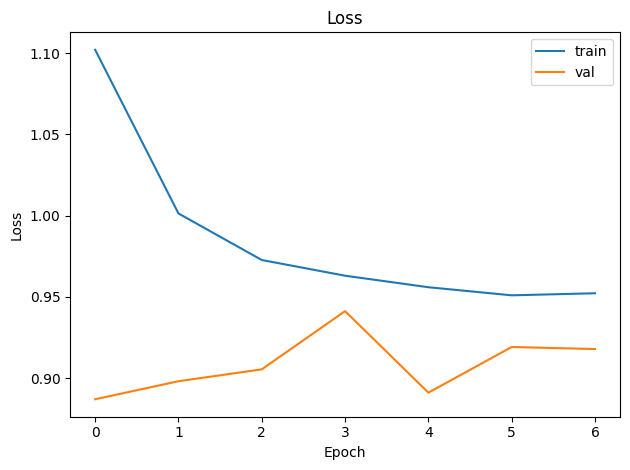

In [15]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend(["train","val"])
plt.tight_layout()
plt.show()

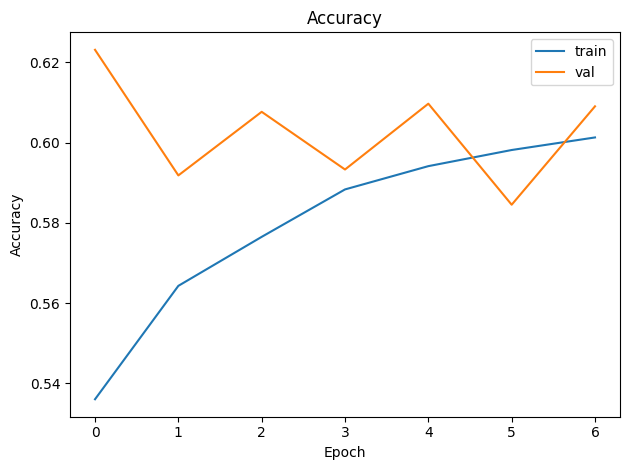

In [16]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend(["train","val"])
plt.tight_layout()
plt.show()

In [17]:
conf_matrix = confusion_matrix(y_test, preds, labels=[0,1,2])
conf_matrix_norm = conf_matrix.astype(float) / conf_matrix.sum(axis=1, keepdims=True)

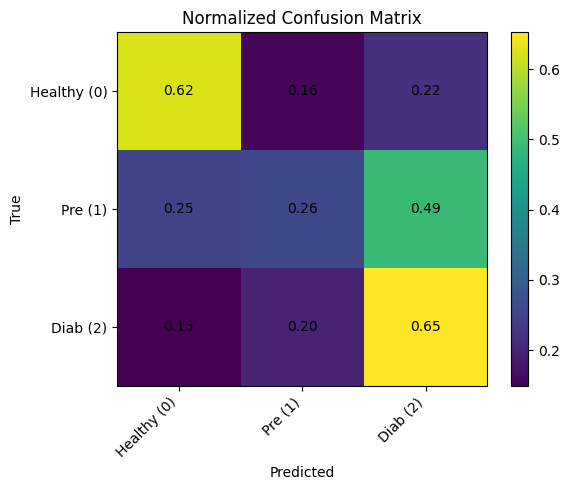

In [18]:
plt.figure(figsize=(6,5))

plt.imshow(conf_matrix_norm, interpolation="nearest", aspect="auto")
plt.title("Normalized Confusion Matrix")
plt.colorbar()

ticks = np.arange(3)
labels = ["Healthy (0)", "Pre (1)", "Diab (2)"]

plt.xticks(ticks, labels, rotation=45, ha="right")
plt.yticks(ticks, labels)

for i in range(3):
    for j in range(3):
        plt.text(j, i, f"{conf_matrix_norm[i,j]:.2f}", ha="center", va="center")


plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [19]:
model.save("keras_mlp_diabetes_full.h5")